# CIFAR-10 ResNet-18 (from primitives) + Visualizations

This notebook implements **ResNet-18** from scratch (only `nn.Conv2d`, `nn.Linear`, etc.) and trains it on **CIFAR-10**.  
We also generate plots and visualizations:

- `curves_cls.png`: Training loss and validation accuracy
- `confusion_matrix.png`: Normalized confusion matrix
- `preds_grid.png`: Grid of correct predictions
- `miscls_grid.png`: Grid of misclassified predictions
- `gradcam_*.png`: Grad-CAM heatmaps for sample images

## 1. Setup
Imports, random seed, and device configuration.

In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Repro & Device 

In [2]:
torch.backends.cudnn.benchmark = True
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. CIFAR-10 Statistics and Utilities
Define dataset statistics, normalization/denormalization helpers.

In [3]:
# CIFAR-10 mean and std
CIFAR_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_STD  = [0.2023, 0.1994, 0.2010]

def denormalize(img_tensor, mean=CIFAR_MEAN, std=CIFAR_STD):
    """Denormalize a tensor image for visualization."""
    x = img_tensor.clone().cpu()
    for c in range(3):
        x[c] = x[c] * std[c] + mean[c]
    x = x.clamp(0, 1).permute(1, 2, 0).numpy()
    x = (x * 255).astype(np.uint8)
    return x

## 3. Data Preparation
Load CIFAR-10 with train/validation split, data augmentation for training, and normalization.

In [4]:
def get_dataloaders(data_dir="./data", batch_size=128, valid_size=0.1, random_seed=42):
    normalize = transforms.Normalize(mean=CIFAR_MEAN, std=CIFAR_STD)

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    transform_eval = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    train_full = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform_train
    )
    test_ds = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform_eval
    )

    # Split into train and validation
    num_train = len(train_full)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]

    train_loader = DataLoader(train_full, batch_size=batch_size,
                              sampler=SubsetRandomSampler(train_idx), num_workers=2)
    val_loader = DataLoader(train_full, batch_size=batch_size,
                            sampler=SubsetRandomSampler(val_idx), num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader


## 4. ResNet-18 from Scratch
Implementation of **BasicBlock** and **ResNet** using only primitives.

In [5]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_ch, out_ch, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.relu(out + identity)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.in_ch = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block,  64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc      = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_ch, blocks, stride):
        downsample = None
        if stride != 1 or self.in_ch != out_ch * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_ch, out_ch * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch * block.expansion),
            )
        layers = [block(self.in_ch, out_ch, stride, downsample)]
        self.in_ch = out_ch * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_ch, out_ch))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes)


## 5. Training Loop
SGD optimizer, cross-entropy loss, validation accuracy tracking.

In [6]:
def train(model, train_loader, val_loader, epochs=20, lr=0.1, wd=5e-4):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    history = {"train_loss": [], "val_acc": []}
    best_val = 0.0

    for ep in range(1, epochs+1):
        model.train()
        run_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
        avg_loss = run_loss / len(train_loader)
        history["train_loss"].append(avg_loss)

        # validation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs).argmax(1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        val_acc = 100.0 * correct / total
        history["val_acc"].append(val_acc)
        print(f"Epoch [{ep}/{epochs}]  loss: {avg_loss:.4f}  val_acc: {val_acc:.2f}%")

        if val_acc > best_val:
            best_val = val_acc
            torch.save(model.state_dict(), "resnet18_cifar10.pth")
    print(f"Best val acc: {best_val:.2f}%")
    return history


## 6. Training Curves
Plot and save training loss and validation accuracy.

In [7]:
import os

# Create results directory
SAVE_DIR = "runs/cls"
os.makedirs(SAVE_DIR, exist_ok=True)

In [8]:
def plot_history(history, save_path=os.path.join(SAVE_DIR, "curves_cls.png")):
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], marker='o', label="Train Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["val_acc"], marker='o', label="Val Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Validation Accuracy"); plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


## 7. Evaluation and Confusion Matrix
Test accuracy and normalized confusion matrix.

In [9]:
@torch.no_grad()
def evaluate_and_confusion(model, test_loader, save_path=os.path.join(SAVE_DIR, "confusion_matrix.png")):
    model.to(device).eval()
    all_preds, all_labels = [], []
    total = correct = 0
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs).argmax(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    test_acc = 100.0 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")

    cm = confusion_matrix(all_labels, all_preds, normalize="true")
    classes = test_loader.dataset.classes
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45, values_format=".2f")
    plt.title("Normalized Confusion Matrix - CIFAR-10")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    return np.array(all_preds), np.array(all_labels)


## 8. Prediction Grids
Display grids of correct and misclassified predictions.

In [10]:
@torch.no_grad()
def collect_test_images_and_preds(model, test_loader):
    model.eval()
    imgs_list, labels_list, preds_list = [], [], []
    for imgs, labels in test_loader:
        preds = model(imgs.to(device)).argmax(1).cpu()
        for i in range(imgs.size(0)):
            imgs_list.append(denormalize(imgs[i]))
        labels_list.extend(labels.numpy().tolist())
        preds_list.extend(preds.numpy().tolist())
    return imgs_list, labels_list, preds_list

def plot_predictions_grid(images, labels, preds, classes, correct=True,
                          save_path=None, num_samples=25):
    if save_path is None:
        save_path = os.path.join(SAVE_DIR, "preds_grid.png" if correct else "miscls_grid.png")

    idxs = [i for i, (y,p) in enumerate(zip(labels, preds)) if (y==p)==correct]
    idxs = idxs[:num_samples]
    n = len(idxs)
    rows = cols = int(np.ceil(np.sqrt(min(n, 25))))
    fig, axes = plt.subplots(rows, cols, figsize=(2.5*cols, 2.5*rows))
    axes = np.array(axes).reshape(rows, cols)
    fig.suptitle("Correct Predictions" if correct else "Misclassified Predictions", fontsize=14)
    for k, ax in enumerate(axes.flatten()):
        if k < n:
            i = idxs[k]
            ax.imshow(images[i])
            ax.set_title(f"P:{classes[preds[i]]}\nT:{classes[labels[i]]}", fontsize=9)
            ax.axis("off")
        else:
            ax.axis("off")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


## 9. Grad-CAM
Implementation of Grad-CAM from scratch for ResNet-18.

In [11]:
from PIL import Image

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.fwd_handle = target_layer.register_forward_hook(self._save_activation)
        self.bwd_handle = target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, inp, out):
        self.activations = out

    def _save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        logits = self.model(input_tensor)
        if class_idx is None:
            class_idx = logits.argmax(1).item()
        score = logits[0, class_idx]
        score.backward(retain_graph=True)

        weights = self.gradients.mean(dim=[2,3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam[0,0].detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() + 1e-8)
        return cam

    def remove_hooks(self):
        self.fwd_handle.remove()
        self.bwd_handle.remove()

def overlay_cam_on_image(img_uint8, cam, alpha=0.5):
    h, w, _ = img_uint8.shape
    cam_resized = np.array(Image.fromarray((cam*255).astype(np.uint8)).resize((w, h)))
    cam_resized = cam_resized.astype(np.float32) / 255.0
    cmap = plt.cm.jet(cam_resized)[..., :3]
    overlay = (alpha * cmap + (1 - alpha) * (img_uint8.astype(np.float32)/255.0))
    overlay = np.clip(overlay, 0, 1)
    overlay_uint8 = (overlay * 255).astype(np.uint8)
    return overlay_uint8

def save_gradcams(model, test_loader, num_samples=3, save_prefix="gradcam_"):
    model.eval()
    target_layer = model.layer4[-1].conv2  # Adjust if your model structure differs
    camgen = GradCAM(model, target_layer)
    saved = 0

    for imgs, labels in test_loader:
        for i in range(imgs.size(0)):
            if saved >= num_samples:
                camgen.remove_hooks()
                return

            img_norm = imgs[i:i+1].to(device)
            img_norm.requires_grad_()  # ✅ Enable gradient tracking on input

            with torch.enable_grad():  # ✅ Allow gradient tracking for Grad-CAM
                cam = camgen.generate(img_norm)

            img_disp = denormalize(imgs[i])  # for visualization
            overlay = overlay_cam_on_image(img_disp, cam, alpha=0.5)
            out_path = os.path.join(SAVE_DIR, f"{save_prefix}{saved}.png")
            Image.fromarray(overlay).save(out_path)
            saved += 1

    camgen.remove_hooks()


## 10. Run Full Pipeline
Train model, plot curves, evaluate on test set, plot confusion matrix, visualize correct/incorrect predictions, and generate Grad-CAMs.

Epoch [1/20]  loss: 1.9629  val_acc: 39.54%
Epoch [2/20]  loss: 1.4620  val_acc: 44.50%
Epoch [3/20]  loss: 1.1795  val_acc: 58.24%
Epoch [4/20]  loss: 0.9675  val_acc: 57.58%
Epoch [5/20]  loss: 0.8413  val_acc: 66.68%
Epoch [6/20]  loss: 0.7198  val_acc: 75.94%
Epoch [7/20]  loss: 0.6336  val_acc: 74.54%
Epoch [8/20]  loss: 0.5801  val_acc: 73.74%
Epoch [9/20]  loss: 0.5500  val_acc: 74.88%
Epoch [10/20]  loss: 0.5213  val_acc: 80.24%
Epoch [11/20]  loss: 0.4938  val_acc: 78.28%
Epoch [12/20]  loss: 0.4806  val_acc: 74.18%
Epoch [13/20]  loss: 0.4640  val_acc: 74.46%
Epoch [14/20]  loss: 0.4530  val_acc: 80.76%
Epoch [15/20]  loss: 0.4340  val_acc: 75.36%
Epoch [16/20]  loss: 0.4307  val_acc: 82.96%
Epoch [17/20]  loss: 0.4215  val_acc: 81.58%
Epoch [18/20]  loss: 0.4150  val_acc: 81.44%
Epoch [19/20]  loss: 0.4059  val_acc: 83.32%
Epoch [20/20]  loss: 0.3960  val_acc: 79.40%
Best val acc: 83.32%


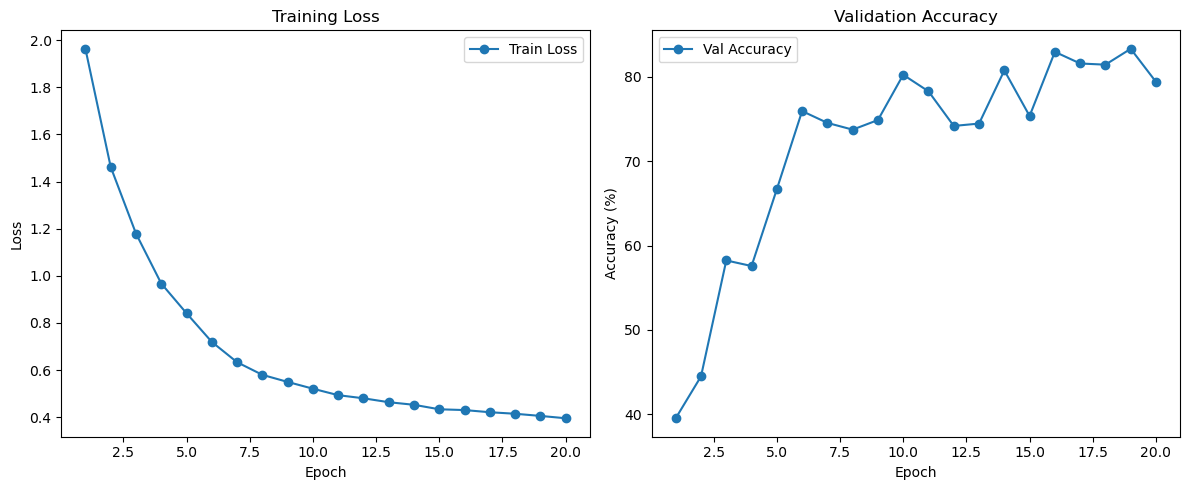

Test Accuracy: 84.11%


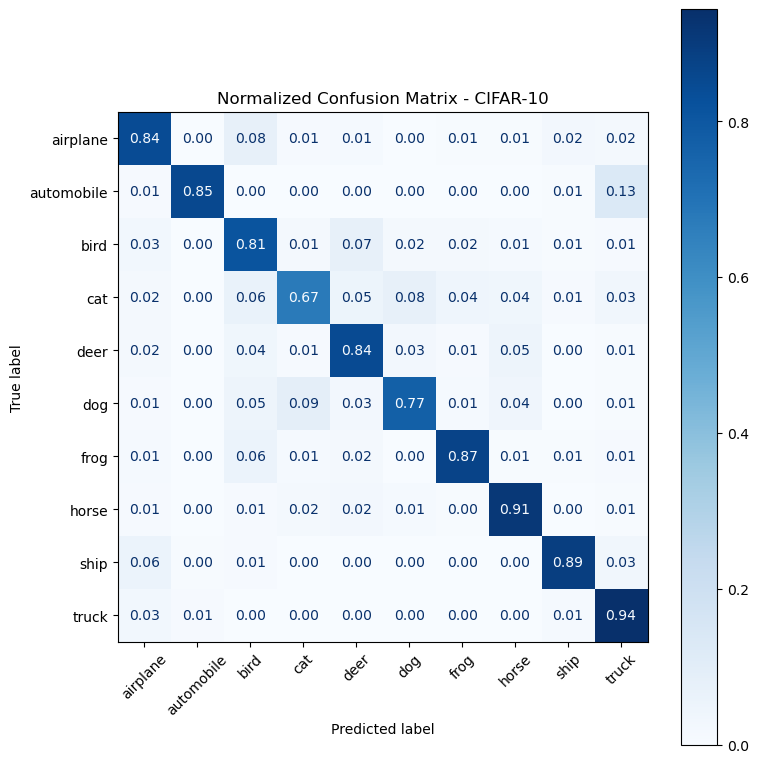

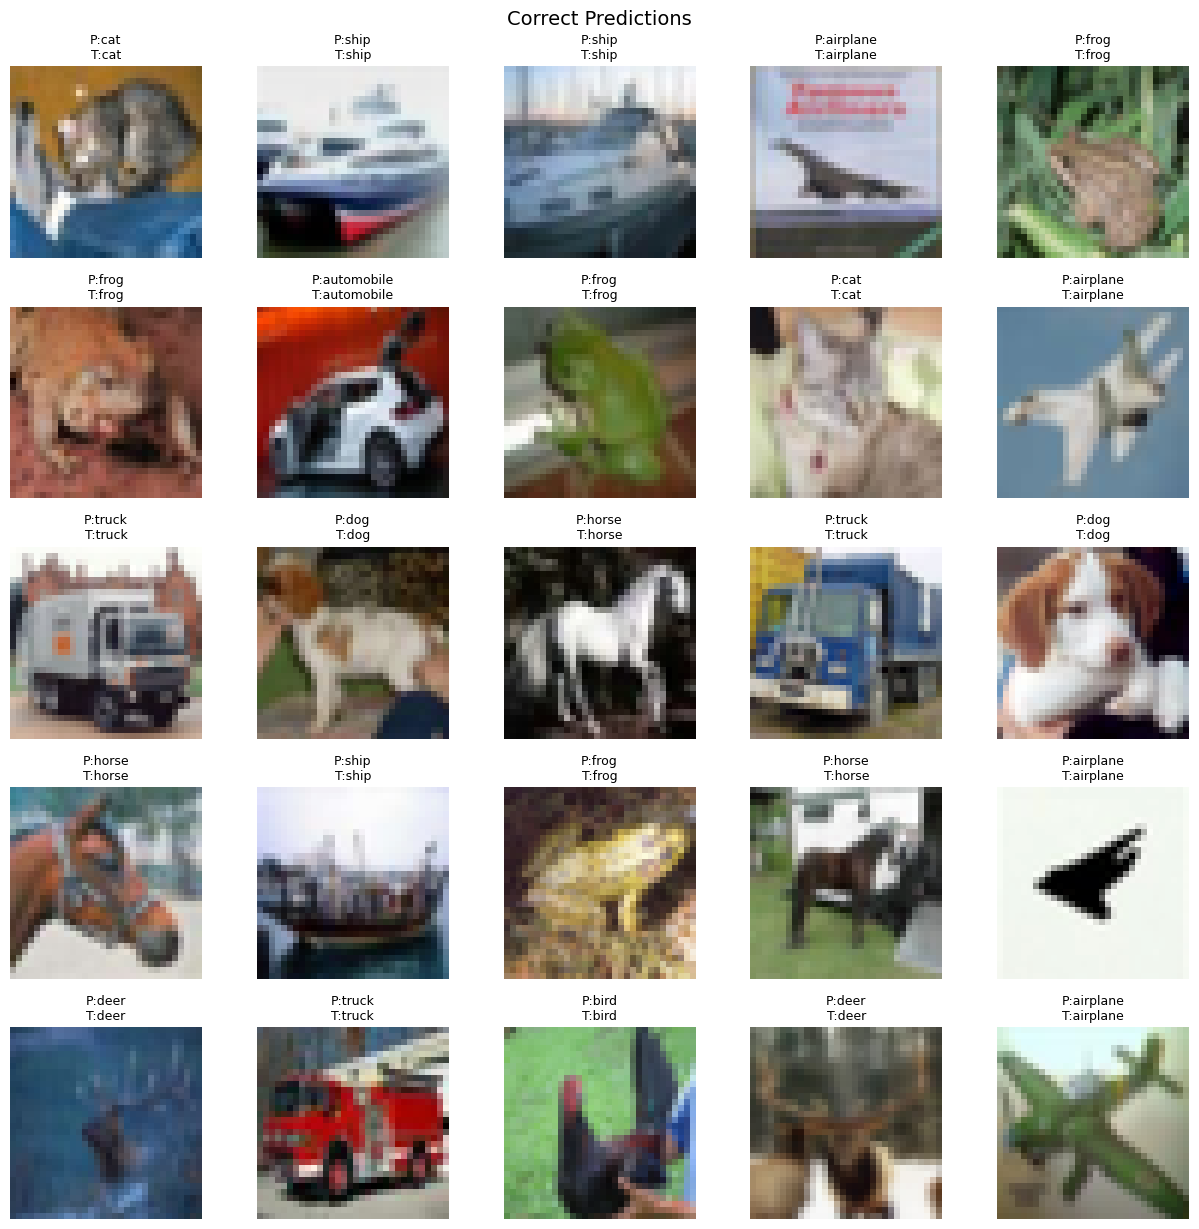

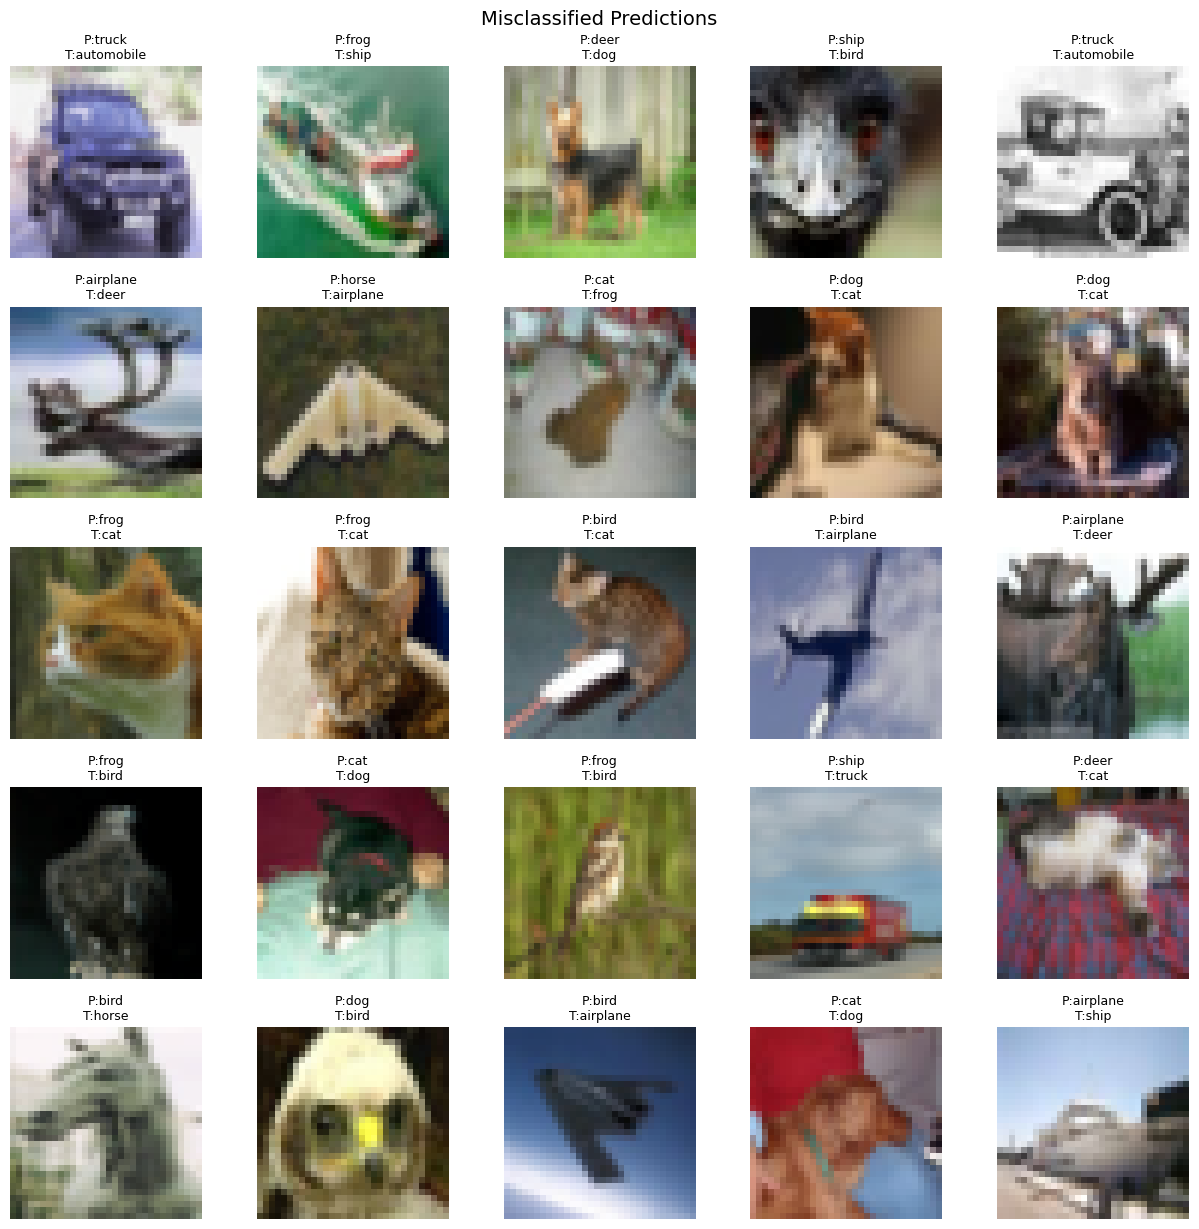

C:\Users\Acer\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [12]:
if __name__ == "__main__":
    train_loader, val_loader, test_loader = get_dataloaders(batch_size=128, valid_size=0.1, random_seed=seed)
    model = ResNet18(num_classes=10)

    # Train
    history = train(model, train_loader, val_loader, epochs=20, lr=0.1, wd=5e-4)
    plot_history(history)  # saves to runs/cls/curves_cls.png

    # Evaluate
    model.load_state_dict(torch.load("resnet18_cifar10.pth", map_location=device))
    preds, labels = evaluate_and_confusion(model, test_loader)  # saves runs/cls/confusion_matrix.png

    # Prediction grids
    images_denorm, labels_list, preds_list = collect_test_images_and_preds(model, test_loader)
    classes = test_loader.dataset.classes
    plot_predictions_grid(images_denorm, labels_list, preds_list, classes, correct=True)   # runs/cls/preds_grid.png
    plot_predictions_grid(images_denorm, labels_list, preds_list, classes, correct=False)  # runs/cls/miscls_grid.png

    # Grad-CAMs
    save_gradcams(model, test_loader, num_samples=4)  # saves runs/cls/gradcam_*.png